In [1]:
import os
import csv
import torch
import random
import hashlib
import itertools
import numpy as np
import polars as pl
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import Counter
import torch.nn.functional as nnF
from datetime import date, datetime
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader, Dataset

from sklearn.feature_extraction.image import img_to_graph
from scipy.sparse import coo_matrix
import os.path as osp

from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import Sequential as GNNSequential
from torch_geometric.loader import DataLoader
import torch.nn.functional as nnF

import torch
from torch_geometric.data import Dataset, download_url

In [2]:
random.seed(234213)

In [3]:
# collecting training image paths and names into lists
training_images_output_path = "../../replicatingAlexNet/images/training_images_processed/"

training_images_processed_path = [
    training_images_output_path + f for f in os.listdir(training_images_output_path)
    if f.endswith('.JPEG')
]

training_images_processed_names = [
    f for f in os.listdir(training_images_output_path)
    if f.endswith('.JPEG')
]

# collecting validation image paths and names into lists
validation_images_output_path = "../../replicatingAlexNet/images/validation_images_processed/"

validation_images_processed_path = [
    validation_images_output_path + f for f in os.listdir(validation_images_output_path)
    if f.endswith('.JPEG')
]

validation_images_processed_names = [
    f for f in os.listdir(validation_images_output_path)
    if f.endswith('.JPEG')
]

# sorting names in ascending order; this is crucial to ensure that the
# proper validation labels are attached to the file names
validation_images_processed_names = sorted(validation_images_processed_names)

labels_w_information = pl.read_csv("../../replicatingAlexNet/images/labels_w_information.csv")
training_labels_for_CEloss = labels_w_information["made_up_label"].to_list()

In [4]:
print(
    img_to_graph(
        F.pil_to_tensor(Image.open(training_images_processed_path[0])), 
        return_as=np.ndarray
    ).shape
)

(196608, 196608)


In [4]:
# USING SOME PREVIOUSLY WRITTEN CODE

# below, I am sampling only labels with greater than 1200 examples and then randomly selecting 25 labels
labels_thousand_plus = [
    label for label, count in Counter(training_labels_for_CEloss).items() 
    if count >= 1200
]
labels_thousand_plus_subset = random.sample(labels_thousand_plus, k=25)

# mapping the subset to numbers between 0-24
# this is needed for the CE loss function
labels_subset_mapped = {
    original_label: new_label for original_label, new_label
    in zip(labels_thousand_plus_subset, range(0, len(labels_thousand_plus_subset)))
}

# a dictionary of indices as keys with the 25 randomly selected labels as values
label_w_index = {
    index: label for index, label 
    in zip(range(0, len(training_labels_for_CEloss)), training_labels_for_CEloss)
    if label in labels_thousand_plus_subset
}

# randomly selecting k of those indices which are then used to 
# select the subset of inputs and labels in training_subset
random_indices = random.sample(list(label_w_index.keys()), k=int(256 * 128))

In [5]:
# loading the validation IDs provided in the Image Net devkit
validation_ILSVRC2010_IDs = []

with open("../../replicatingAlexNet/devkit-1.0/data/ILSVRC2010_validation_ground_truth.txt") as file:
    while line := file.readline():
        validation_ILSVRC2010_IDs.append(int(line.rstrip()))

In [6]:
# converting the IDs to labels for the validation data
validation_true_labels = [i - 1 for i in validation_ILSVRC2010_IDs]

validation_subset_25_labels = {
    image_name: label for image_name, label 
    in zip(validation_images_processed_names, validation_true_labels) 
    if label in labels_thousand_plus_subset
}

# sampling based on the random indices but storing 
# the 0-24 values using the labels_subset_mapped dictionary
training_labels_subset_sampled_converted = [
    labels_subset_mapped.get(training_labels_for_CEloss[i]) for i in random_indices
]

# sampling image names based on the random indices
training_image_names_subset_sampled = [
    labels_w_information["image_name"][i] for i in random_indices
]

validation_labels_subset_sampled_converted = [
    labels_subset_mapped.get(i) for i in list(validation_subset_25_labels.values())
]

In [9]:
test_list = [
    img_to_graph(
        F.pil_to_tensor(Image.open(f"{training_images_output_path}/{i}")), 
        return_as=np.ndarray
    ) for i in training_image_names_subset_sampled[:1]
]

In [10]:
test_list[0]

array([[ 67,   1,   0, ...,   0,   0,   0],
       [  1,  66,   1, ...,   0,   0,   0],
       [  0,   1,  65, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 151, 232,   0],
       [  0,   0,   0, ..., 232, 175, 248],
       [  0,   0,   0, ...,   0, 248, 183]], dtype=uint8)

In [11]:
size_in_bytes = torch.vstack((torch.from_numpy(test_list[0]),)).element_size() \
                * torch.vstack((torch.from_numpy(test_list[0]),)).nelement()
size_in_gbs = size_in_bytes / (1024 ** 3)

print(
    f"The estimated total size of {(1 / len(training_image_names_subset_sampled)):.5f}th "
    f"of the augmented dataset is {(1 * size_in_gbs):.2f} gigabytes."
)
print(
    f"The estimated total size of the augmented training set is "
    f"{(len(training_image_names_subset_sampled) * size_in_gbs / 1024):.2f} terabytes."
)

The estimated total size of 0.00003th of the augmented dataset is 36.00 gigabytes.
The estimated total size of the augmented training set is 1152.00 terabytes.


oh no

In [12]:
test_list[0].shape

(196608, 196608)

In [13]:
im1 = Image.open(str(training_images_output_path + training_image_names_subset_sampled[0]))

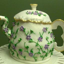

In [14]:
im1 = im1.resize((64, 64))
im1

In [15]:
im1.size

(64, 64)

In [16]:
img_to_graph(
    F.pil_to_tensor(im1), 
    return_as=np.ndarray
).shape

(12288, 12288)

In [17]:
size_in_bytes = torch.vstack((torch.from_numpy(img_to_graph(F.pil_to_tensor(im1), return_as=np.ndarray)),)).element_size() \
                * torch.vstack((torch.from_numpy(img_to_graph(F.pil_to_tensor(im1), return_as=np.ndarray)),)).nelement()
size_in_gbs = size_in_bytes / (1024 ** 3)

print(
    f"The estimated total size of {(1 / len(training_image_names_subset_sampled)):.5f}th "
    f"of the augmented dataset is {(1 * size_in_gbs):.2f} gigabytes."
)
print(
    f"The estimated total size of the augmented training set is "
    f"{(len(training_image_names_subset_sampled) * size_in_gbs / 1024):.2f} terabytes."
)

The estimated total size of 0.00003th of the augmented dataset is 0.14 gigabytes.
The estimated total size of the augmented training set is 4.50 terabytes.


Ok, much better. **Now, the question is: how bad is the loss of information from such a drastic size reduction?**

It isn't ideal that in addition to the input format for the graph model (just the adjacency matrix), there is another variable of uncertainty (a vastly reduced matrix size compared to one from a 256 x 256 image).

It may be better to _sparsify_ the adjacency matrix of the full image to reduce its size, but for now, I will trudge along.

In [7]:
def process_images_to_graphs(
    file_name
):
    image = Image.open(file_name)
    image = image.resize((64, 64))
    graph = torch.from_numpy(img_to_graph(F.pil_to_tensor(im1), return_as=np.ndarray)).to("mps")
    return graph

In [32]:
#[process_images_to_graphs(training_images_output_path + i) for i in training_image_names_subset_sampled[:100]]

In [8]:
128 * 0.14

17.92

In [11]:
class ImageGraphDataset(Dataset):
    def __init__(
        self, 
        root, 
        image_names, 
        labels, 
        transform=None, 
        pre_transform=None, 
        pre_filter=None
    ):
        self.image_names = image_names
        self.labels = labels
        self.root = root
        super().__init__(root, transform, pre_transform, pre_filter)

    @property
    def raw_file_names(self):
        return self.image_names

    @property
    def processed_file_names(self):
        return [f'data_{i}.pt' for i in range(len(self.image_names))]

    def download(self):
        pass

    def process(self):
        for i, (image_name, label) in enumerate(zip(self.image_names, self.labels)):
            raw_path = osp.join(self.root, image_name)
            x, edge_index, edge_attr = self.process_image_to_graph(raw_path)
            
            data = Data(
                x=x,
                edge_index=edge_index,
                edge_attr=edge_attr,
                y=torch.tensor([label], dtype=torch.long)
            )

            if self.pre_filter is not None and not self.pre_filter(data):
                continue

            if self.pre_transform is not None:
                data = self.pre_transform(data)

            torch.save(data, osp.join(self.processed_dir, f'data_{i}.pt'))

    def process_image_to_graph(self, file_name):
        image = Image.open(file_name)
        image = image.resize((64, 64))
        image_array = np.array(image)
        
        # creating graph from image
        graph = img_to_graph(image_array)
        
        # converting to COO format
        coo = coo_matrix(graph)
        
        # creating node features, edge indices, and weights
        x = torch.from_numpy(image_array.reshape(-1, 1)).float()
        edge_index = torch.from_numpy(np.vstack((coo.row, coo.col))).long()
        edge_attr = torch.from_numpy(coo.data).float().unsqueeze(1)
        
        return x, edge_index, edge_attr

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'), weights_only=False)
        return data

In [12]:
train_dataset = ImageGraphDataset(
    root=training_images_output_path,
    image_names=training_image_names_subset_sampled,
    labels=training_labels_subset_sampled_converted
)

val_dataset = ImageGraphDataset(
    root=validation_images_output_path,
    image_names=list(validation_subset_25_labels.keys()),
    labels=validation_labels_subset_sampled_converted
)

In [16]:
# GNN designed by Claude based on my AlexNet implementation

class AlexNetInspiredGNN(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features, num_classes):
        super(AlexNetInspiredGNN, self).__init__()
        
        self.conv1 = GCNConv(num_node_features, 96)
        self.pool1 = TopKPooling(96, ratio=0.5)
        
        self.conv2 = GCNConv(96, 256)
        self.pool2 = TopKPooling(256, ratio=0.5)
        
        self.conv3 = GCNConv(256, 384)
        
        self.conv4 = GCNConv(384, 384)
        
        self.conv5 = GCNConv(384, 256)
        self.pool5 = TopKPooling(256, ratio=0.5)
        
        self.fc1 = torch.nn.Linear(256, 4096)
        self.fc2 = torch.nn.Linear(4096, 4096)
        self.fc3 = torch.nn.Linear(4096, num_classes)

    def forward(self, *args):
        if len(args) == 1 and hasattr(args[0], 'x'):
            data = args[0]
            x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        elif len(args) == 4:
            x, edge_index, edge_attr, batch = args
        else:
            raise ValueError("Invalid input. Expecting either a single Data object or x, edge_index, edge_attr, batch")
        
        # Conv1 + Pool1
        x = nnF.relu(self.conv1(x, edge_index, edge_attr))
        x, edge_index, edge_attr, batch, _, _ = self.pool1(x, edge_index, edge_attr, batch)
        
        # Conv2 + Pool2
        x = nnF.relu(self.conv2(x, edge_index, edge_attr))
        x, edge_index, edge_attr, batch, _, _ = self.pool2(x, edge_index, edge_attr, batch)
        
        # Conv3
        x = nnF.relu(self.conv3(x, edge_index, edge_attr))
        
        # Conv4
        x = nnF.relu(self.conv4(x, edge_index, edge_attr))
        
        # Conv5 + Pool5
        x = nnF.relu(self.conv5(x, edge_index, edge_attr))
        x, edge_index, edge_attr, batch, _, _ = self.pool5(x, edge_index, edge_attr, batch)
        
        # Global pooling
        x = global_mean_pool(x, batch)
        
        # Fully connected layers
        x = nnF.relu(self.fc1(x))
        x = nnF.dropout(x, p=0.5, training=self.training)
        x = nnF.relu(self.fc2(x))
        x = nnF.dropout(x, p=0.5, training=self.training)
        x = self.fc3(x)
        
        return nnF.log_softmax(x, dim=1)

In [ ]:
def write_to_csv(file_name, epoch, train_loss, train_acc, val_loss, val_acc, lr):
    with open(file_name, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch, train_loss, train_acc, val_loss, val_acc, lr])

def train_and_validate(model, train_dataset, val_dataset, num_epochs=100, batch_size=32, lr=0.01, log_file_name='gnn_training_log.csv'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10, verbose=True)
    criterion = torch.nn.NLLLoss()

    # create and write header to CSV file
    with open(log_file_name, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'Train Loss', 'Train Accuracy', 'Val Loss', 'Val Accuracy', 'Learning Rate'])

    for epoch in range(num_epochs):
        # Training block
        model.train()
        running_loss = 0
        correct_train = 0
        total_train = 0

        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * data.num_graphs
            _, predicted = torch.max(out, 1)
            total_train += data.y.size(0)
            correct_train += predicted.eq(data.y).sum().item()

        # computing training metrics
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_train / total_train

        # validation block
        model.eval()
        correct_val = 0
        total_val = 0
        val_loss_count = 0

        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)
                val_out = model(data.x, data.edge_index, data.edge_attr, data.batch)
                val_loss = criterion(val_out, data.y)
                val_loss_count += val_loss.item() * data.num_graphs

                _, val_predicted = torch.max(val_out, 1)
                total_val += data.y.size(0)
                correct_val += val_predicted.eq(data.y).sum().item()

        # computing validation metrics
        val_epoch_loss = val_loss_count / len(val_loader.dataset)
        val_epoch_acc = correct_val / total_val

        # learning rate scheduler
        scheduler.step(val_epoch_acc)
        current_lr = scheduler.get_last_lr()[0]

        print(
            f"{str(epoch + 1).zfill(2)}/{num_epochs}, "
            f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}, "
            f"Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_acc:.4f}, "
            f"Learning Rate: {current_lr}"
        )

        write_to_csv(log_file_name, epoch + 1, epoch_loss, epoch_acc, val_epoch_loss, val_epoch_acc, current_lr)

    print(f"Trial training done! Loss and accuracy values were saved to {log_file_name}")

num_node_features = 1 
num_edge_features = 1 
num_classes = 25  

model = AlexNetInspiredGNN(num_node_features, num_edge_features, num_classes)
train_and_validate(model, train_dataset, val_dataset, num_epochs=100, batch_size=32, lr=0.01)